Files already downloaded and verified
Files already downloaded and verified
Epoch [1/11], Step [2000/5000], Loss: 2.1012
Epoch [1/11], Step [4000/5000], Loss: 1.7710
Epoch [2/11], Step [2000/5000], Loss: 1.1924
Epoch [2/11], Step [4000/5000], Loss: 1.2399
Epoch [3/11], Step [2000/5000], Loss: 0.6169
Epoch [3/11], Step [4000/5000], Loss: 0.9778
Epoch [4/11], Step [2000/5000], Loss: 1.1494
Epoch [4/11], Step [4000/5000], Loss: 0.9367
Epoch [5/11], Step [2000/5000], Loss: 0.5412
Epoch [5/11], Step [4000/5000], Loss: 0.9378
Epoch [6/11], Step [2000/5000], Loss: 1.0056
Epoch [6/11], Step [4000/5000], Loss: 0.6943
Epoch [7/11], Step [2000/5000], Loss: 0.9116
Epoch [7/11], Step [4000/5000], Loss: 0.6612
Epoch [8/11], Step [2000/5000], Loss: 0.4648
Epoch [8/11], Step [4000/5000], Loss: 0.2843
Epoch [9/11], Step [2000/5000], Loss: 0.2231
Epoch [9/11], Step [4000/5000], Loss: 0.5168
Epoch [10/11], Step [2000/5000], Loss: 0.5138
Epoch [10/11], Step [4000/5000], Loss: 0.3763
Epoch [11/11], Step [2

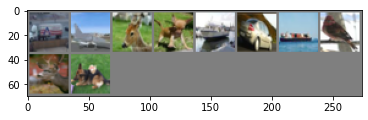

Labels for Images
tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])
Prediction for Image 1
truck
Prediction for Image 2
plane
Prediction for Image 3
deer
Prediction for Image 4
dog
Prediction for Image 5
ship
Prediction for Image 6
car
Prediction for Image 7
ship
Prediction for Image 8
bird
Prediction for Image 9
bird
Prediction for Image 10
dog


In [3]:
#importing necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 11
batch_size = 10
learning_rate = 0.005

# We transform them to Tensors of normalized range [-1, 1]
# We also augment the data by performing a random horizontal flip to the data and a random crop
transform_train = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #Normalize the data set using the mean and standard deviation z = x- mean/ std
                               transforms.RandomHorizontalFlip(), transforms.RandomCrop(size=32)])

transform_test = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #Normalize the data set using the mean and standard deviation z = x- mean/ std 

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
# Importing the train_dataset and test_dataset and then creating the appropraite data loaders
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#image Tensor structure: (batchsize, color channels, size, size)

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) #images have 3 color channels, output is 6, 5*5 shape, kernal has weights and biases
        self.pool = nn.MaxPool2d(2, 2) #kernal size of 2, stride of 2
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128*8*8, 200) #calculate the size without the batch size in the front
        self.fc2 = nn.Linear(200, 10)
    def forward(self, x):
        x = (F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128*8*8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # original shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward propogation and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)] #[0,0,0,0,0,0,0,0,0,0]
    n_class_samples = [0 for i in range(10)] #[0,0,0,0,0,0,0,0,0,0]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i] 
            pred = predicted[i] 
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')
        
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)] #[0,0,0,0,0,0,0,0,0,0]
    n_class_samples = [0 for i in range(10)] #[0,0,0,0,0,0,0,0,0,0]
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i] 
            pred = predicted[i] 
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')
        
examples = iter(test_loader)
samples, labels = examples.next()

def imshow(img):
    img = img/2 + 0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))

print("Labels for Images")
print(labels)

preds = _, predictions = torch.max(model(images), 1)

for i in range(10):
    print(f"Prediction for Image {i+1}")
    print(classes[predictions[i]])
        